In [1]:
from gerrychain import Graph

In [2]:
# Read Nebraska county graph from the json file "NE.county.json"
filepath = 'C:\\Users\\jayde\\Downloads\\'
filename = 'NE.county.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filepath + filename )

In [3]:
# Let's impose a 1% population deviation (+/- 0.5%)
deviation = 0.01

import math
k = 3          # number of districts
total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 605737 and U = 611824 and k = 3


In [4]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)  # y[u,v] equals one when edge {u,v} is cut

Academic license - for non-commercial use only - expires 2021-06-22
Using license file C:\Users\jayde\gurobi.lic


In [5]:
# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [6]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {i,j} is cut if i is assigned to district v but j is not.
m.addConstrs( x[i,v] - x[j,v] <= y[i,j] for i,j in G.edges for v in range(k))

m.update()

In [7]:
# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars(G.nodes, k, vtype=GRB.BINARY)

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG
import networkx as nx
DG = nx.DiGraph(G) # directed version of G
f = m.addVars(DG.edges, vtype=GRB.CONTINUOUS)

In [8]:
# The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in DG.nodes) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in DG.nodes for j in range(k) )  

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[u,v] - f[v,u] for u in DG.neighbors(v) ) >= 1 - M * gp.quicksum( r[v,j] for j in range(k)) for v in G.nodes)

# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * (1 - y[i,j]) for (i,j) in G.edges )

m.update()

In [9]:
# solve IP model
m.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1398 rows, 1251 columns and 5649 nonzeros
Model fingerprint: 0xfb2df3bf
Variable types: 462 continuous, 789 integer (789 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+05]
Presolve time: 0.01s
Presolved: 1398 rows, 1251 columns, 5646 nonzeros
Variable types: 462 continuous, 789 integer (789 binary)

Root relaxation: objective 6.666667e-01, 580 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.00000    0  289          -    1.00000      -     -    0s
     0     0    1.72963    0  294          -    1.72963      -     -    0s
     0     0    4.08251    0  293          -    4.08251

In [10]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME10"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])

The number of cut edges is 19.0
District 0 has population 608839 and contains counties ['Burt', 'Dakota', 'Thurston', 'Dodge', 'Washington', 'Douglas']
District 1 has population 609327 and contains counties ['Saunders', 'Pawnee', 'Colfax', 'Seward', 'Richardson', 'Saline', 'Jefferson', 'Otoe', 'Sarpy', 'Cass', 'Johnson', 'Butler', 'Nemaha', 'Gage', 'Lancaster']
District 2 has population 608175 and contains counties ['Dawson', 'Thomas', 'Antelope', 'Garfield', 'Sioux', 'Deuel', 'Boyd', 'Thayer', 'Hitchcock', 'Banner', 'Furnas', 'Clay', 'Merrick', 'Brown', 'Arthur', 'Sheridan', 'Wayne', 'Cuming', 'Garden', 'Keith', 'Pierce', 'Sherman', 'Dundy', 'Stanton', 'Cheyenne', 'Box Butte', 'Wheeler', 'Lincoln', 'Hooker', 'Red Willow', 'Grant', 'Chase', 'Scotts Bluff', 'Greeley', 'Webster', 'Cherry', 'Boone', 'Dawes', 'Frontier', 'Nuckolls', 'Kearney', 'Dixon', 'Howard', 'Keya Paha', 'Logan', 'Cedar', 'Loup', 'Polk', 'Blaine', 'Kimball', 'Gosper', 'Harlan', 'Phelps', 'Hamilton', 'Knox', 'Morrill', 

In [11]:
# Let's draw it on a map
import geopandas as gpd

In [12]:
# Read Nebraska county shapefile from "NE.counties.shp.shp"
filepath = 'C:\\Users\\jayde\\Downloads\\'
filename = 'NE_counties.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

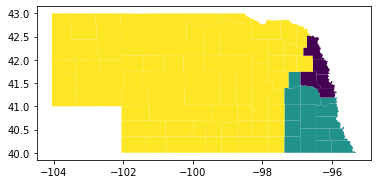

In [13]:
# Which district is each county assigned to?
assignment = [ -1 for u in G.nodes ]
    
# for each district j
for j in range(len(districts)):
    
    # for each node i in this district
    for i in districts[j]:
        
        # What is its GEOID?
        geoID = G.nodes[i]["GEOID10"]
        
        # Need to find this GEOID in the dataframe
        for u in G.nodes:
            if geoID == df['GEOID10'][u]: # Found it
                assignment[u] = j # Node u from the dataframe should be assigned to district j

# Now add the assignments to a column of the dataframe and map it
df['assignment'] = assignment
my_fig = df.plot(column='assignment').get_figure()